In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

# Stability Test 1
### How stable is peak detection algo when changing interpolation of final back diffused data?

Load core data and specifications and define all data of interest.

Choose core.

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


In [4]:
sites = ['Crete', 'SiteA', 'SiteB', 'SiteE', 'SiteG']

In [115]:
site = 'SiteG'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


Define interpolation size array from high resoultion to low resolution.
create empty lists to store data in.

In [116]:
delta_arr = np.arange(0.01,0.11,0.04)
diffLens = []
depths = []
datas = []
peakss = [] 
delta_arr

array([0.01, 0.05, 0.09])

Define instance of back diffusion class for data from specific site.

In [117]:
inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, 32, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depthOG, dataOG, diffLenOG, peaksOG, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.01)


Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.669 cm
Final sigma: 8.55 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.040


For all sampling sizes (deltas) compute diffusion length resulting in 32 peaks.

In [118]:
for i in range(len(delta_arr)):
    print('\n')
    depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True, newDelta=delta_arr[i])
    depths.append(depth1)
    datas.append(data)
    peakss.append(peaks)
    diffLens.append(diffLen)




Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.668 cm
Final sigma: 8.40 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.010


Starting sigma: 6.66 [cm]
100. Npeaks: 31, diffLen: 7.669 cm
200. Npeaks: 32, diffLen: 8.669 cm
Final sigma: 8.76 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.050


Starting sigma: 6.66 [cm]
100. Npeaks: 28, diffLen: 7.669 cm
200. Npeaks: 32, diffLen: 8.673 cm
Final sigma: 8.88 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.091


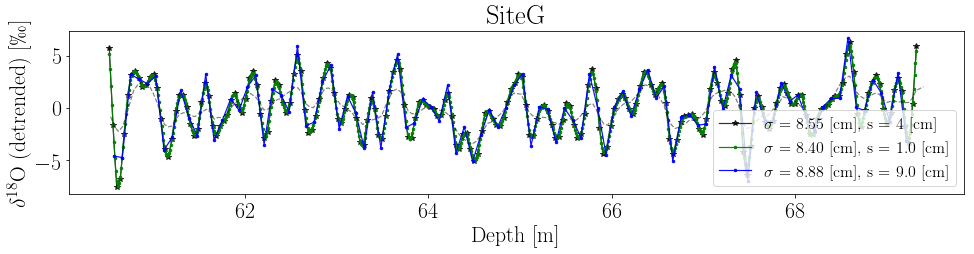

In [119]:

fig, ax = plt.subplots(figsize=(14,4))
colors = ['green','darkgreen','blue']
ax.plot(depthOG,dataOG, '-', marker='*', label=f'$\sigma$ = {diffLenOG*100:.2f} [cm], s = 4 [cm]', lw=1.2, color='k',alpha=0.8)
for i in [0,2]:#,len(delta_arr)):
    depth = depths[i]
    data = datas[i]
    ax.plot(depth,data, '-', marker='.', label=f'$\sigma$ = {diffLens[i]*100:.2f} [cm], s = {delta_arr[i]*100} [cm]', lw=1.2, color=colors[i], alpha=0.95, ms=5)
    #ax.plot(depth[peakss[i]],data[peakss[i]],'.', color='maroon', ms=10, label=f'Peaks, N = {len(peakss[i])}')
ax.set(title=site, xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]')
ax.legend(fontsize=16)
ax.plot(data_d18O_LT['depth'], data_d18O_LT['d18O']- np.mean(data_d18O_LT['d18O']),ls='--',label=f'Data, s = 4 [cm]', color='k', lw=1.2, alpha=0.5)

fig.tight_layout()
#fig.savefig('../WrittenWork/Figures/'+site+'ResampledAFDecon1And9cm.jpg', bbox_inches='tight')

Save data of interest (deltas and diffusion lengths) as .txt file.

In [54]:

#df_Site = pd.DataFrame({'diffLens':diffLens, 'deltas':delta_arr})

#df_Site.to_csv('../Data/'+site+'_DiffLensVdelta.txt',sep='\t', index=False)

Plot diffusion length vs. sample size for all cores.

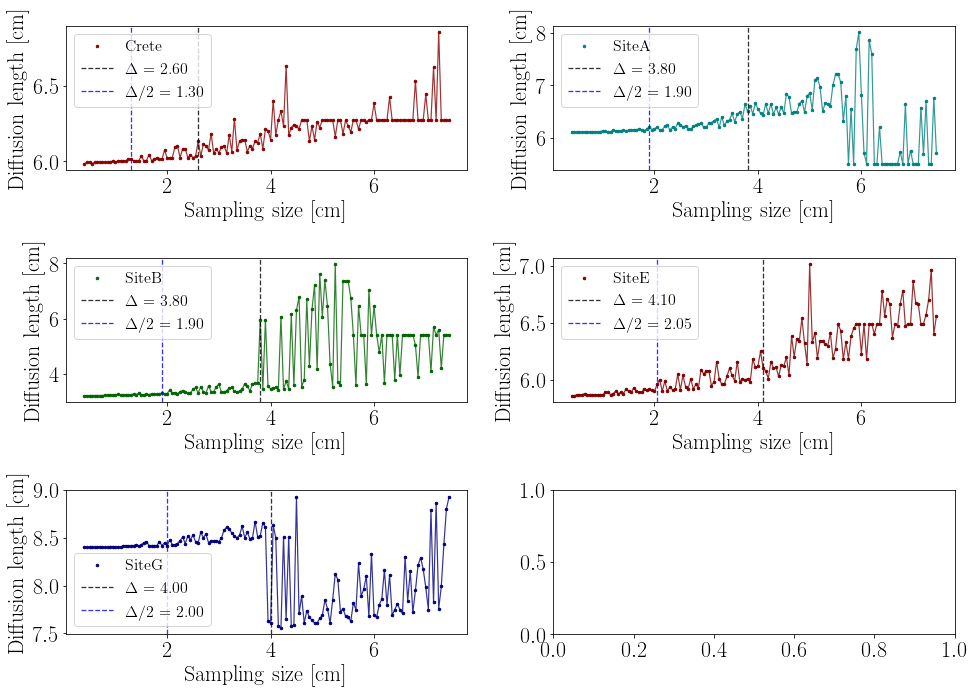

In [126]:
sites = ['Crete', 'SiteA', 'SiteB', 'SiteE', 'SiteG']
delta0s = [0.026, 0.038, 0.038, 0.041, 0.040]

colors = ['darkred','teal','darkgreen','maroon','navy']
fig,axes = plt.subplots(3,2,figsize=(14,10))#, sharex=True)#, sharey=True)

i = 0
for site, ax in zip(sites,axes.flatten()):
    Site = pd.read_csv('../Data/'+site + '_DiffLensVdelta.txt', sep='\t')

    DiffLens = Site['diffLens']
    Deltas = Site['deltas']
    ax.plot(Deltas*100, DiffLens*100,'.', marker='.', ms=5, lw=1.2, label=site, color=colors[i])
    ax.plot(Deltas*100, DiffLens*100,'-', lw=1.2,  alpha=0.8, color=colors[i],label='')
    ax.axvline(x=delta0s[i]*100, color='k',ls='--', lw=1.3, alpha=0.8, label=f'$\Delta$ = {delta0s[i]*100:.2f}')
    ax.axvline(x=(delta0s[i]/2)*100, color='b',ls='--', lw=1.3, alpha=0.8, label=f'$\Delta$/2 = {(delta0s[i]/2)*100:.2f}')
    ax.set(ylabel='Diffusion length [cm]', xlabel='Sampling size [cm]')
    ax.legend(fontsize=16)
    i+=1
    
fig.tight_layout()

fig.savefig('../WrittenWork/Figures/SamlingVsDiffLen.jpg', bbox_inches='tight')